In [4]:
%matplotlib inline

<IPython.core.display.Javascript object>


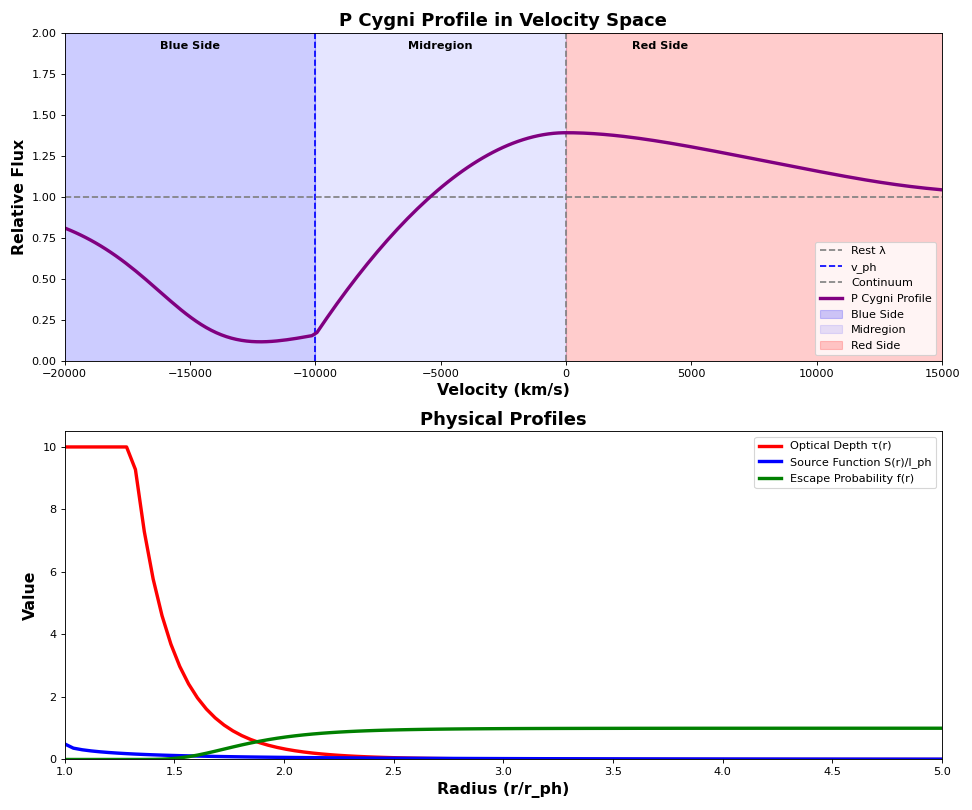

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import ipywidgets as widgets
from IPython.display import display

# Set plotting style
#plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['font.size'] = 12

class PCygniSimulator:
    def __init__(self):
        """Initialize the P Cygni profile simulator."""
        # Model parameters
        self.tau0 = 5.0  # Optical depth at photosphere
        self.n_tau = 8.0  # Power-law index for optical depth
        self.source_type = "dilution"  # "dilution" or "power"
        self.n_source = 2.0  # Power-law index for source function
        self.vph = 10000.0  # Photospheric velocity in km/s
        
        # Calculation parameters
        self.rmax = 5.0  # Maximum atmosphere radius in r_ph units
        self.show_inversion = False  # Whether to show inversion results
        self.fixed_y_axis = True  # Whether to use fixed y-axis scale
        self.fixed_x_axis = True  # Whether to use fixed x-axis scale
        self.velocity_zoom = "profile"  # Zoom level for the velocity axis
        
        # Create the widgets and output areas
        self.create_widgets()
        self.fig = plt.figure(figsize=(12, 10))
        self.ax1 = self.fig.add_subplot(2, 1, 1)
        self.ax2 = self.fig.add_subplot(2, 1, 2)
        
        # Initial calculation and plot
        self.calculate_profiles()
        self.update_plots()
    
    def create_widgets(self):
        """Create interactive widgets."""
        # Model parameter sliders
        self.tau0_slider = widgets.FloatSlider(
            value=self.tau0, min=0.0, max=500.0, step=0.1,
            description='τ₀:', continuous_update=True
        )
        self.tau0_slider.observe(self.on_parameter_change, names='value')
        
        self.n_tau_slider = widgets.FloatSlider(
            value=self.n_tau, min=1.0, max=20.0, step=0.1,
            description='τ(r) ∝ r^(-n):', continuous_update=True
        )
        self.n_tau_slider.observe(self.on_parameter_change, names='value')
        
        self.vph_slider = widgets.FloatSlider(
            value=self.vph, min=0.0, max=30000.0, step=500.0,
            description='v_ph (km/s):', continuous_update=True
        )
        self.vph_slider.observe(self.on_parameter_change, names='value')
        
        self.source_type_dropdown = widgets.Dropdown(
            options=[('Resonance Scattering (W(r))', 'dilution'), ('Power Law (r^(-n))', 'power')],
            value=self.source_type,
            description='Source Function:',
        )
        self.source_type_dropdown.observe(self.on_parameter_change, names='value')
        
        self.n_source_slider = widgets.FloatSlider(
            value=self.n_source, min=0.0, max=6.0, step=0.1,
            description='S(r) ∝ r^(-n):', continuous_update=True,
            disabled=(self.source_type != 'power')
        )
        self.n_source_slider.observe(self.on_parameter_change, names='value')
        
        # Calculation settings
        self.rmax_slider = widgets.FloatSlider(
            value=self.rmax, min=2.0, max=10.0, step=0.5,
            description='r_max/r_ph:', continuous_update=True
        )
        self.rmax_slider.observe(self.on_parameter_change, names='value')
        
        self.show_inversion_checkbox = widgets.Checkbox(
            value=self.show_inversion,
            description='Show τ(r) from inversion formula (eq. 7)',
        )
        self.show_inversion_checkbox.observe(self.on_parameter_change, names='value')
        
        self.fixed_y_axis_checkbox = widgets.Checkbox(
            value=self.fixed_y_axis,
            description='Fixed Y-axis scale [0,1.2]',
        )
        self.fixed_y_axis_checkbox.observe(self.on_parameter_change, names='value')
        
        self.fixed_x_axis_checkbox = widgets.Checkbox(
            value=self.fixed_x_axis,
            description='Fixed X-axis scale (independent of v_ph)',
        )
        self.fixed_x_axis_checkbox.observe(self.on_parameter_change, names='value')
        
        self.velocity_zoom_buttons = widgets.ToggleButtons(
            options=['full', 'profile', 'feature'],
            value=self.velocity_zoom,
            description='Velocity zoom:',
            disabled=False,
            button_style='',
            tooltips=['Full Range', 'Profile View', 'Feature Focus'],
        )
        self.velocity_zoom_buttons.observe(self.on_parameter_change, names='value')
        
        # Layout the widgets
        param_widgets = widgets.VBox([
            widgets.HTML(value="<h3>Model Parameters</h3>"),
            self.vph_slider,
            self.tau0_slider,
            self.n_tau_slider,
            self.source_type_dropdown,
            self.n_source_slider
        ])
        
        calc_widgets = widgets.VBox([
            widgets.HTML(value="<h3>Display Settings</h3>"),
            self.rmax_slider,
            self.show_inversion_checkbox,
            self.fixed_y_axis_checkbox,
            self.fixed_x_axis_checkbox,
            self.velocity_zoom_buttons
        ])
        
        self.widgets_box = widgets.HBox([param_widgets, calc_widgets])
    
    def on_parameter_change(self, change):
        """Handle parameter changes."""
        # Update model parameters
        self.tau0 = self.tau0_slider.value
        self.n_tau = self.n_tau_slider.value
        self.vph = self.vph_slider.value
        self.source_type = self.source_type_dropdown.value
        self.n_source = self.n_source_slider.value
        self.rmax = self.rmax_slider.value
        self.show_inversion = self.show_inversion_checkbox.value
        self.fixed_y_axis = self.fixed_y_axis_checkbox.value
        self.fixed_x_axis = self.fixed_x_axis_checkbox.value
        self.velocity_zoom = self.velocity_zoom_buttons.value
        
        # Update n_source slider status based on source_type
        self.n_source_slider.disabled = (self.source_type != 'power')
        
        # Recalculate and update plots
        self.calculate_profiles()
        self.update_plots()
    
    def optical_depth(self, r):
        """Calculate optical depth at radius r."""
        if np.isscalar(r):
            if r < 1:
                return self.tau0
            return self.tau0 * (r ** -self.n_tau)
        else:
            result = np.zeros_like(r)
            mask = r < 1
            result[mask] = self.tau0
            mask = r >= 1
            result[mask] = self.tau0 * (r[mask] ** -self.n_tau)
            return result
    
    def escape_prob(self, r):
        """Calculate escape probability at radius r."""
        return np.exp(-self.optical_depth(r))
    
    def dilution_factor(self, r):
        """Calculate dilution factor at radius r."""
        if np.isscalar(r):
            if r <= 1:
                return 0.5
            return 0.5 * (1 - np.sqrt(1 - 1/(r*r)))
        else:
            result = np.zeros_like(r)
            mask = r <= 1
            result[mask] = 0.5
            mask = r > 1
            result[mask] = 0.5 * (1 - np.sqrt(1 - 1/(r[mask]*r[mask])))
            return result
    
    def source_function(self, r):
        """Calculate source function at radius r."""
        if np.isscalar(r):
            if r < 1:
                return 1.0
            
            if self.source_type == "dilution":
                return self.dilution_factor(r)
            else:
                return r ** -self.n_source
        else:
            result = np.zeros_like(r)
            mask = r < 1
            result[mask] = 1.0
            mask = r >= 1
            
            if self.source_type == "dilution":
                result[mask] = self.dilution_factor(r[mask])
            else:
                result[mask] = r[mask] ** -self.n_source
            
            return result
    
    def calculate_flux(self, velocity):
        """Calculate flux for a given velocity."""
        # Convert to normalized z-coordinate
        z = velocity / self.vph
        
        if z >= 0:
            # Red side (equation 3 from paper)
            # F(z)/(2π) = (1/2)r_ph² + ∫ S(r)[1-f(r)]r dr
            
            # Photospheric contribution (normalized)
            flux = 0.5
            
            # Source term: integrate from √(1+z²) to rmax
            r_min = np.sqrt(1 + z*z)
            
            def integrand(r):
                return self.source_function(r) * (1 - self.escape_prob(r)) * r
            
            source_term, _ = integrate.quad(integrand, r_min, self.rmax)
            flux += source_term
            
            # Normalize to continuum level (0.5)
            return flux / 0.5
        
        elif z > -1:
            # Midregion (equation 5 from paper)
            # F(z)/(2π) = (1/2)p₀² + ∫ S(r)[1-f(r)]r dr + ∫ f(r)r dr
            
            # Calculate p₀² = 1 - z²
            p0_squared = 1 - z*z
            
            # Direct photospheric contribution
            flux = 0.5 * p0_squared
            
            # Source term: integrate from √(z²+1) to rmax
            r_min = np.sqrt(z*z + 1)
            
            def source_integrand(r):
                return self.source_function(r) * (1 - self.escape_prob(r)) * r
            
            source_term, _ = integrate.quad(source_integrand, r_min, self.rmax)
            flux += source_term
            
            # Absorption term: integrate from 1 to √(z²+1)
            def absorption_integrand(r):
                return self.escape_prob(r) * r
            
            absorption_term, _ = integrate.quad(absorption_integrand, 1, r_min)
            flux += absorption_term
            
            # Normalize to continuum level (0.5)
            return flux / 0.5
        
        else:
            # Blue side (equation 10 from paper) - FIXED INTEGRATION LIMITS
            abs_z = abs(z)
            
            # Calculate geometry consistently with the midregion
            r_min = np.sqrt(z*z + 1)
            flux = 0
            
            # Source term: FIXED - Use r_min instead of abs_z for consistency
            def source_integrand(r):
                return self.source_function(r) * (1 - self.escape_prob(r)) * r
            
            source_term, _ = integrate.quad(source_integrand, r_min, self.rmax)
            flux += source_term
            
            # Handle the region between abs_z and r_min consistently
            if abs_z < r_min:
                # If abs_z < r_min, we need consistent handling with midregion
                def absorption_integrand(r):
                    return self.escape_prob(r) * r
                
                absorption_term, _ = integrate.quad(absorption_integrand, abs_z, r_min)
                flux += absorption_term
            
            # Normalize to continuum level (0.5)
            return flux / 0.5
    
    def calculate_profiles(self):
        """Calculate line profile and physical profiles."""
        # Generate velocity grid
        v_min = -3 * self.vph
        v_max = 3 * self.vph
        velocities = np.linspace(v_min, v_max, 300)  # Using fewer points for speed
        
        # Calculate fluxes
        fluxes = []
        for v in velocities:
            fluxes.append(self.calculate_flux(v))
        fluxes = np.array(fluxes)
        
        # Store profile data
        self.line_profile = {
            'velocity': velocities,
            'flux': fluxes,
            'z': velocities / self.vph
        }
        
        # Calculate physical profiles
        r_grid = np.linspace(1, self.rmax, 100)  # Using fewer points for speed
        self.physical_profiles = {
            'r': r_grid,
            'tau': self.optical_depth(r_grid),
            'source': self.source_function(r_grid),
            'escape': self.escape_prob(r_grid)
        }
        
        # Calculate inversion profile if needed
        if self.show_inversion:
            # Only calculate for midregion where inversion formula applies
            midregion_velocities = velocities[(velocities < 0) & (velocities > -self.vph)]
            
            # For each velocity in midregion, calculate r and flux derivative
            inversion_r = []
            inversion_tau = []
            
            for velocity in midregion_velocities:
                z = velocity / self.vph
                r = np.sqrt(1 + z*z)
                
                # Find nearest points for numerical derivative
                idx = np.searchsorted(velocities, velocity)
                if idx <= 1 or idx >= len(velocities) - 1:
                    continue
                
                # Calculate flux derivative numerically using central difference
                v1 = velocities[idx-1]
                v2 = velocities[idx+1]
                f1 = fluxes[idx-1]
                f2 = fluxes[idx+1]
                df_dv = (f2 - f1) / (v2 - v1)
                
                # Convert to df/dz
                df_dz = df_dv * self.vph
                
                # Calculate f(r) using equation 7
                f_r = 1 - (1 / (2 * abs(z))) * df_dz
                
                # Calculate τ(r) = -ln(f(r))
                if 0.0001 <= f_r <= 0.9999:
                    tau_r = -np.log(f_r)
                    inversion_r.append(r)
                    inversion_tau.append(tau_r)
            
            self.inversion_profile = {
                'r': np.array(inversion_r),
                'tau': np.array(inversion_tau)
            }
    
    def get_velocity_domain(self):
        """Get the velocity domain based on zoom setting."""
        if self.fixed_x_axis:
            # Use fixed values that don't depend on vph
            if self.velocity_zoom == "full":
                return [-30000, 30000]
            elif self.velocity_zoom == "profile":
                return [-20000, 15000]
            elif self.velocity_zoom == "feature":
                return [-15000, 10000]
            else:
                return [-30000, 30000]
        else:
            # Scale with vph as in the original code
            if self.velocity_zoom == "full":
                return [-3 * self.vph, 3 * self.vph]
            elif self.velocity_zoom == "profile":
                return [-2 * self.vph, 1.5 * self.vph]
            elif self.velocity_zoom == "feature":
                return [-1.5 * self.vph, 1 * self.vph]
            else:
                return [-3 * self.vph, 3 * self.vph]
    
    def get_flux_range(self):
        """Get the flux range based on fixed_y_axis setting."""
        if self.fixed_y_axis:
            return [0, 2.0]
        else:
            fluxes = self.line_profile['flux']
            return [max(0, min(fluxes) * 0.9), max(fluxes) * 1.1]
    
    def update_plots(self):
        """Update the plots with current data."""
        # Clear previous plots
        self.ax1.clear()
        self.ax2.clear()
        
        # Get domains for axes
        v_domain = self.get_velocity_domain()
        flux_range = self.get_flux_range()
        
        # Plot 1: P Cygni Profile
        # Add background regions
        self.ax1.axvspan(v_domain[0], -self.vph, alpha=0.2, color='blue', label='Blue Side')
        self.ax1.axvspan(-self.vph, 0, alpha=0.1, color='blue', label='Midregion')
        self.ax1.axvspan(0, v_domain[1], alpha=0.2, color='red', label='Red Side')
        
        # Add reference lines
        self.ax1.axvline(x=0, color='gray', linestyle='--', label='Rest λ')
        self.ax1.axvline(x=-self.vph, color='blue', linestyle='--', label='v_ph')
        self.ax1.axhline(y=1, color='gray', linestyle='--', label='Continuum')
        
        # Plot the profile
        self.ax1.plot(self.line_profile['velocity'], self.line_profile['flux'], 
                     color='purple', linewidth=3, label='P Cygni Profile')
        
        # Add labels and title
        self.ax1.set_xlabel('Velocity (km/s)', fontsize=14, fontweight='bold')
        self.ax1.set_ylabel('Relative Flux', fontsize=14, fontweight='bold')
        self.ax1.set_title('P Cygni Profile in Velocity Space', fontsize=16, fontweight='bold')
        
        # Set axis limits
        self.ax1.set_xlim(v_domain)
        self.ax1.set_ylim(flux_range)
        
        # Add region labels
        self.ax1.text((v_domain[0] + (-self.vph))/2, flux_range[1] * 0.95, 
                     'Blue Side', ha='center', fontweight='bold')
        self.ax1.text(-self.vph/2, flux_range[1] * 0.95, 
                     'Midregion', ha='center', fontweight='bold')
        self.ax1.text(v_domain[1]/4, flux_range[1] * 0.95, 
                     'Red Side', ha='center', fontweight='bold')
        
        # Add legend
        self.ax1.legend(loc='lower right')
        
        # Plot 2: Physical Profiles
        self.ax2.plot(self.physical_profiles['r'], 
                     np.minimum(10, self.physical_profiles['tau']), 
                     color='red', linewidth=3, label='Optical Depth τ(r)')
        
        self.ax2.plot(self.physical_profiles['r'], self.physical_profiles['source'], 
                     color='blue', linewidth=3, label='Source Function S(r)/I_ph')
        
        self.ax2.plot(self.physical_profiles['r'], self.physical_profiles['escape'], 
                     color='green', linewidth=3, label='Escape Probability f(r)')
        
        # Plot inversion profile if enabled
        if self.show_inversion and hasattr(self, 'inversion_profile'):
            self.ax2.scatter(self.inversion_profile['r'], self.inversion_profile['tau'], 
                            color='purple', label='τ(r) from Inversion', s=50)
        
        # Add labels and title
        self.ax2.set_xlabel('Radius (r/r_ph)', fontsize=14, fontweight='bold')
        self.ax2.set_ylabel('Value', fontsize=14, fontweight='bold')
        self.ax2.set_title('Physical Profiles', fontsize=16, fontweight='bold')
        
        # Set axis limits
        self.ax2.set_xlim([1, self.rmax])
        self.ax2.set_ylim([0, None])
        
        # Add legend
        self.ax2.legend(loc='upper right')
        
        # Adjust layout and display
        plt.tight_layout()
        plt.draw()
        # Force the figure to update
        self.fig.canvas.draw_idle()
    
    def display_all(self):
        """Display the widgets and plots."""
        display(self.widgets_box)
        plt.show()

# Create explanation text for the theory
def show_theory():
    """Display theoretical explanations."""
    theory_text = """
    <h2>P Cygni Profile in the Sobolev Approximation</h2>
    <p>Based on "A Complete Analytic Inversion of Supernova Lines in the Sobolev Approximation" 
    by Kasen et al. (2002, ApJ, 565, 380)</p>
    
    <h3>Key Equations:</h3>
    <ul>
        <li>Optical depth: τ(r) = τ₀ (r/r_ph)^(-n)</li>
        <li>Escape probability: f(r) = e^(-τ(r))</li>
        <li>Source function (resonance scattering): S(r) = I_ph × W(r) = I_ph × (1/2)[1-√(1-(r_ph/r)²)]</li>
        <li>Source function (power law): S(r) = I_ph × (r/r_ph)^(-n)</li>
    </ul>
    
    <h3>Flux Equations from the Kasen+2002:</h3>
    <ul>
        <li>Red side (v ≥ 0): F(z)/(2π) = (1/2)r_ph² + ∫ S(r)[1-f(r)]r dr</li>
        <li>Midregion (-v_ph < v < 0): F(z)/(2π) = (1/2)p₀² + ∫ S(r)[1-f(r)]r dr + ∫ f(r)r dr</li>
        <li>Blue side (v ≤ -v_ph): F(z)/(2π) = ∫ S(r)[1-f(r)]r dr + ∫ f(r)r dr</li>
    </ul>
    
    <h3>Key Inversion Formulas:</h3>
    <ul>
        <li>Equation 7 (Midregion): f(r) = e^(-τ(r)) = 1 - (1/(2|z|))(df/dz)</li>
        <li>Equation 9 (Red side): S(r) = -(r_ph²/(1-f(r)))(1/(2z))(df/dz)</li>
        <li>Equation 13 (Blue side): Extension of τ(r) to larger radii</li>
    </ul>
    
    <h3>Key Regions of the P Cygni Profile:</h3>
    <div style="display: flex; justify-content: space-between;">
        <div style="background-color: #e6f0ff; padding: 10px; margin: 5px; width: 31%;">
            <h4>Blue Side (v ≤ -v_ph)</h4>
            <p>Pure absorption at velocities higher than the photospheric velocity.</p>
            <p>The blue edge of the profile contains information about both the optical depth and source function at large radii.</p>
        </div>
        
        <div style="background-color: #e6e6ff; padding: 10px; margin: 5px; width: 31%;">
            <h4>Midregion (-v_ph < v < 0)</h4>
            <p>This region directly reveals the optical depth near the photosphere.</p>
            <p>The steepness of this region is directly proportional to the optical depth - steeper transitions indicate higher opacity.</p>
        </div>
        
        <div style="background-color: #ffe6e6; padding: 10px; margin: 5px; width: 31%;">
            <h4>Red Side (v ≥ 0)</h4>
            <p>Pure emission component from scattered photons.</p>
            <p>The shape of this region depends on both optical depth and source function.</p>
        </div>
    </div>
    
    <h3>Conclusions from the Paper:</h3>
    <ul>
        <li>The midregion slope directly indicates the optical depth near the photosphere - this is independent of the source function.</li>
        <li>In the Sobolev approximation, the midregion must always increase (or remain flat) toward the red side.</li>
        <li>Emission features cannot peak blueward of the rest wavelength under these assumptions.</li>
        <li>If observed profiles violate these constraints, it indicates that one or more assumptions are invalid, such as:
            <ul>
                <li>Continuous opacity may be important</li>
                <li>The atmosphere may not be spherically symmetric</li>
                <li>Line blending may be occurring</li>
                <li>Relativistic effects may be significant at high velocities</li>
            </ul>
        </li>
    </ul>
    """
    
    from IPython.display import HTML
    display(HTML(theory_text))

# Function to run the simulator
def run_simulator():
    """Run the P Cygni profile simulator."""
    # Display theory
    show_theory()
    
    # Create and display simulator
    simulator = PCygniSimulator()
    simulator.display_all()

# Ensure matplotlib is in inline mode
%matplotlib notebook

# Run the simulator
run_simulator()